# Data Understanding
In this notebook I am using the MNIST Digits dataset.

About the dataset: The dataset consists of 10 classes of handwritten Images pictures each with a number between 0-9.

In [ ]:
#importing the necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import cv2

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt 

import scipy
import IPython
import keras 
import sklearn.metrics as Metric_tools
from sklearn.model_selection import train_test_split


%load_ext autoreload
%autoreload 2



In [ ]:
# Reading the folder architecture of Kaggle to get the dataset path.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Reading the Train and Test Datasets.
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

Underesting the shape and other information about the datasets could give us a better intution to solve the problem

In [ ]:
# Let's see the shape of the train and test data
print(train_data.shape, test_data.shape)

In [ ]:
print("Training Data : ")
train_data.head(3).iloc[:,:17]

In [ ]:
print("Testing Data : ")
test_data.head(3).iloc[:,:17]

In the train file, the first column is the label (0..9, output). You can change .iloc[:, this] to see more columns. Each column has a max value of 255 and a min value of 0. That is each pixel has values between 0..255.
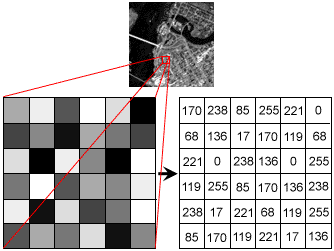

Let's now see the description of both these two datasets. Descritption is a method with dataframes, it allows us to see the statistical values of a dataset. Like for example, the mean, the std (standard deviation), the max and min values etc,...

In [ ]:
print("Description of the training : ")
disc_train = train_data.describe().T
disc_train.iloc[1:10, :]

In [ ]:
print("Description of the testing : ")
disc_test = test_data.describe().T
disc_test.iloc[:10, :]

Let's visualize the mean of each pixel in a bar plot.

Before Scaling :

* The content in the following plots represents the data before scaling, you can see that the features vary. The first features have 0 in the mean value, that's because all the values in the first features are zeros (Black background).

In [ ]:
fig, ax_arr = plt.subplots(1, 2, figsize=(14, 4))
fig.subplots_adjust(wspace=0.25, hspace=0.025)

ax_arr = ax_arr.ravel()

sets = iter([(disc_train, "training"), (disc_test, "testing")])
for i, ax in enumerate(ax_arr):
    set_ = next(sets)
    ax.plot(set_[0].loc[:, "mean"], label="Mean")
    ax.set_title("Mean of the {} features.".format(set_[1]))
    ax.set_xlabel('Pixels')
    ax.set_ylabel('Mean')
    ax.set_xticks([0, 120, 250, 370, 480, 600, 720])
    ax.legend(loc="upper left", shadow=True, frameon=True, framealpha=0.9)
    ax.set_ylim([0, 150])
plt.show()

# Normalization :

Normalizing the data helps with converging to the global minima, instead of having a lot of local minima.
Similarly, the goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. For machine learning, every dataset does not require normalization. It is required only when features have different ranges.For example, consider a data set containing two features, age, and income(x2). Where age ranges from 0–100, while income ranges from 0–100,000 and higher. Income is about 1,000 times larger than age. So, these two features are in very different ranges. When we do further analysis, like multivariate linear regression, for example, the attributed income will intrinsically influence the result more due to its larger value. But this doesn’t necessarily mean it is more important as a predictor. So we normalize the data to bring all the variables to the same range.

In [ ]:
train_data_norm = train_data.iloc[:, 1:] / 255.0
test_data_norm = test_data / 255.0

Describing the normalized dataset again.

In [ ]:
disc_train = train_data_norm.describe().T
disc_test = test_data_norm.describe().T

Plotting the mean to see what's the difference

In [ ]:
fig, ax_arr = plt.subplots(1, 2, figsize=(14, 4))
fig.subplots_adjust(wspace=0.25, hspace=0.025)

ax_arr = ax_arr.ravel()

sets = iter([(disc_train, "training"), (disc_test, "testing")])
for i, ax in enumerate(ax_arr):
    set_ = next(sets)
    ax.plot(set_[0].loc[:, "mean"], label="Mean")
    ax.set_title("Mean of the {} features.".format(set_[1]))
    ax.set_xlabel('Pixels')
    ax.set_ylabel('Mean')
    ax.set_xticks([0, 120, 250, 370, 480, 600, 720])
    ax.legend(loc="upper left", shadow=True, frameon=True, framealpha=0.9)
    ax.set_ylim([0, 150])
plt.show()

* As you see above, the mean of all the features is close to zero, that means all of the features have a similar mean.
* This will help increasing the performance of course.

# Display examples in the dataset

In [ ]:
rand_indices = np.random.choice(train_data_norm.shape[0], 64, replace=False)
examples = train_data_norm.iloc[rand_indices, :]

fig, ax_arr = plt.subplots(8, 8, figsize=(6, 5))
fig.subplots_adjust(wspace=.025, hspace=.025)

ax_arr = ax_arr.ravel()
for i, ax in enumerate(ax_arr):
    ax.imshow(examples.iloc[i, :].values.reshape(28, 28), cmap="gray")
    ax.axis("off")
    
plt.show()    

* Let's see how the values in the output target are distributed.

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(train_data.iloc[:, 0], bins=10, edgecolor="black", facecolor="lightblue")
plt.xlabel('Number in the output.')
plt.ylabel('Frequency.')
plt.title('Distribution of numbers.')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlim([0, 9])
pass

# Preparing the inputs :
We're going to prepare the input images, and put them in the correct shape. The shapes should be (num_examples,  nh,nw,nc ).

* nc  = Number of channels (1 Gray-scale).

* nh  = Height of images.

* nw  = Width of images.

In [ ]:
num_examples_train = train_data.shape[0]
num_examples_test = test_data.shape[0]
n_h = 32
n_w = 32
n_c = 3

In [ ]:
Train_input_images = np.zeros((num_examples_train, n_h, n_w, n_c))
Test_input_images = np.zeros((num_examples_test, n_h, n_w, n_c))

In [ ]:
for example in range(num_examples_train):
    Train_input_images[example,:28,:28,0] = train_data.iloc[example, 1:].values.reshape(28,28)
    Train_input_images[example,:28,:28,1] = train_data.iloc[example, 1:].values.reshape(28,28)
    Train_input_images[example,:28,:28,2] = train_data.iloc[example, 1:].values.reshape(28,28)
    
for example in range(num_examples_test):
    Test_input_images[example,:28,:28,0] = test_data.iloc[example, :].values.reshape(28,28)
    Test_input_images[example,:28,:28,1] = test_data.iloc[example, :].values.reshape(28,28)
    Test_input_images[example,:28,:28,2] = test_data.iloc[example, :].values.reshape(28,28)

In [ ]:
for example in range(num_examples_train):
    Train_input_images[example] = cv2.resize(Train_input_images[example], (n_h, n_w))
    
for example in range(num_examples_test):
    Test_input_images[example] = cv2.resize(Test_input_images[example], (n_h, n_w))

In [ ]:
Train_labels = np.array(train_data.iloc[:, 0])

In [ ]:
print("Shape of train input images : ", Train_input_images.shape)
print("Shape of test input images : ", Test_input_images.shape)
print("Shape of train labels : ", Train_labels.shape)

# Data augmentation :
* Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

* Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.

* The Keras deep learning neural network library provides the capability to fit models using image data augmentation via the ImageDataGenerator class.
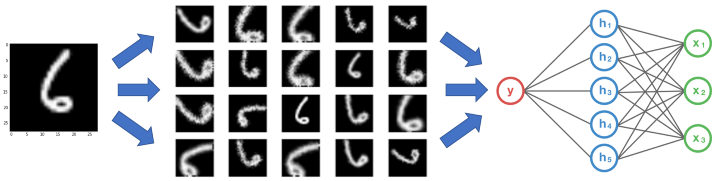

Before training, we'll first modify your images to be better suited for training a convolutional neural network. For this task we'll use the Keras ImageDataGenerator function to perform data preprocessing and data augmentation.

This class also provides support for basic data augmentation such as random horizontal flipping of images. We also use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1 (this will faciliate model training by standardizing the input distribution). The generator also converts our single channel Digits (gray-scale) to a three-channel format by repeating the values in the image across all channels (we will want this because the pre-trained model that we'll use requires three-channel inputs).

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=27,
    width_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    samplewise_center=True,
    samplewise_std_normalization=True
)
validation_datagen = ImageDataGenerator()

In [ ]:
pretrained_model = keras.applications.resnet50.ResNet50(input_shape=(n_h, n_w, n_c),
                                                        include_top=False, weights='imagenet')

model = keras.Sequential([
    pretrained_model,
    keras.layers.Flatten(),
    keras.layers.Dense(units=60, activation='relu'),
    keras.layers.Dense(units=10, activation='softmax')
])

In [ ]:
model.summary()

In [ ]:
Optimizer = 'RMSprop'

model.compile(optimizer=Optimizer, 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# Adding the development set

In [ ]:
train_images, dev_images, train_labels, dev_labels = train_test_split(Train_input_images, 
                                                                      Train_labels,
                                                                      test_size=0.1, train_size=0.9,
                                                                      shuffle=True,
                                                                      random_state=44)
test_images = Test_input_images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen  = ImageDataGenerator(
    rotation_range=27,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=False)

validation_datagen = ImageDataGenerator()

In [ ]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.999999):
            print("Stop training!")
            self.model.stop_training = True

In [ ]:
callbacks = myCallback()

In [ ]:
EPOCHS = 5
batch_size = 212

history = model.fit_generator(train_datagen.flow(train_images,train_labels, batch_size=batch_size),
                         steps_per_epoch=train_images.shape[0] / batch_size, 
                         epochs=EPOCHS,   
                         validation_data=validation_datagen.flow(dev_images,dev_labels,
                                                                 batch_size=batch_size),
                         validation_steps=dev_images.shape[0] / batch_size,
                         callbacks=[callbacks])

In [ ]:
plt.style.use('ggplot')  
 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.15, hspace=0.025)
ax = ax.ravel()

ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].legend(loc="upper left", shadow=True, frameon=True, fancybox=True, framealpha=0.9)

ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and validation loss')
ax[1].legend(loc="upper right", shadow=True, frameon=True, fancybox=True, framealpha=0.9)

plt.show()

# Submitting the prediction.

In [ ]:
# submission = pd.read_csv('../input/digit-recognizer-submission/submission.csv')
# submission.to_csv('digit_submission.csv', index=False)

# NEW Insight

In [ ]:
# Reading the folder architecture of Kaggle to get the dataset path.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Reading the Train and Test Datasets.
mnist_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
mnist_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

Underesting the shape and other information about the datasets could give us a better intution to solve the problem

In [ ]:
# Let's see the shape of the train and test data
print(mnist_train.shape, mnist_test.shape)

In [ ]:
mnist_train.info()

In [ ]:
mnist_test.info()

In [ ]:
# Looking at a few rows from the data isn't a bad idea.
mnist_train.head()

In [ ]:
# and yeah, here you will see the basic statistical insights of the numerical features of train data.
mnist_train.describe()

# Data Cleaning and Normalization

In [ ]:
mnist_train.columns[mnist_train.isnull().any()]

We do not have any missing values in the datasets, therfore, the data is clean already

# Data Normalization


In [ ]:
# dividing the data into the input and output features to train make the model learn based on what to take in and what to throw out.
mnist_train_data = mnist_train.loc[:, "pixel0":]
mnist_train_label = mnist_train.loc[:, "label"]

# Notmailzing the images array to be in the range of 0-1 by dividing them by the max possible value. 
# Here is it 255 as we have 255 value range for pixels of an image. 
mnist_train_data = mnist_train_data/255.0
mnist_test = mnist_test/255.0

# Visulaize a single digit with an array


In [ ]:
# Let's make some beautiful plots.
digit_array = mnist_train.loc[6, "pixel0":]
arr = np.array(digit_array) 

#.reshape(a, (28,28))
image_array = np.reshape(arr, (28,28))

digit_img = plt.imshow(image_array, cmap=plt.cm.binary)
plt.colorbar(digit_img)
print("IMAGE LABEL: {}".format(mnist_train.loc[3, "label"]))


# PCA Implementation on MNIST Digits



# 1) Using manual approach:

a) Compute standardization of data


In [ ]:
from sklearn.preprocessing import StandardScaler

standardized_scalar = StandardScaler()
standardized_data = standardized_scalar.fit_transform(mnist_train_data)
standardized_data.shape

b) Calculate covariance matrix S(dxd)

In [ ]:
cov_matrix = np.matmul(standardized_data.T, standardized_data)
cov_matrix.shape

c) Calculate Eigen values and eigen vectors

In [ ]:
from scipy.linalg import eigh

lambdas, vectors = eigh(cov_matrix, eigvals=(782, 783))
vectors.shape

In [ ]:
vectors = vectors.T
vectors.shape

d) Calculate unit vectors U1=V1 and new coordinates

In [ ]:
new_coordinates = np.matmul(vectors, standardized_data.T)
print(new_coordinates.shape)
new_coordinates = np.vstack((new_coordinates, mnist_train_label)).T

In [ ]:
df_new = pd.DataFrame(new_coordinates, columns=["f1", "f2", "labels"])
df_new.head()

e) Plot FacetGrid using seaborn


In [ ]:
sns.FacetGrid(df_new, hue="labels", size=6).map(plt.scatter, "f1", "f2").add_legend()
plt.show()

# 2) Using Sci-kit Learn library:

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(standardized_data)
pca_data.shape

In [ ]:
pca_data = np.vstack((pca_data.T, mnist_train_label)).T

In [ ]:
df_PCA = pd.DataFrame(new_coordinates, columns=["f1", "f2", "labels"])
df_PCA.head()

In [ ]:
sns.FacetGrid(df_new, hue="labels", size=12).map(plt.scatter, "f1", "f2").add_legend()
plt.savefig("PCA_FacetGrid.png")
plt.show()

# PCA Dimension Reduction

In [ ]:
pca.n_components = 784
pca_data = pca.fit_transform(standardized_data)
percent_variance_retained = pca.explained_variance_ / np.sum(pca.explained_variance_)

cum_variance_retained = np.cumsum(percent_variance_retained)

In [ ]:
plt.figure(1, figsize=(10, 6))
plt.clf()
plt.plot(cum_variance_retained, linewidth=2)
plt.axis("tight")
plt.grid()
plt.xlabel("number of compoments")
plt.ylabel("cumulative variance retained")
plt.savefig("pca_cumulative_variance.png")
plt.show()

In [ ]:
# Converting dataframe into arrays
mnist_train_data = np.array(mnist_train_data)
mnist_train_label = np.array(mnist_train_label)

In [ ]:
# Reshaping the input shapes to get it in the shape which the model expects to recieve later.
mnist_train_data = mnist_train_data.reshape(mnist_train_data.shape[0], 28, 28, 1)
print(mnist_train_data.shape, mnist_train_label.shape)

# Model Building Process

In [ ]:
# But first import some cool libraries before getting our hands dirty!! 
# TensorFlow is Google's open source AI framework and we are using is here to build model.
# Keras is built on top of Tensorflow and gives us
# NO MORE GEEKY STUFF, Know more about them here:  https://www.tensorflow.org     https://keras.io

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D
from tensorflow.keras.optimizers import Adadelta
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler

# Encoding train labels

In [ ]:
# Encoding the labels and making them as the class value and finally converting them as categorical values.
nclasses = mnist_train_label.max() - mnist_train_label.min() + 1
mnist_train_label = to_categorical(mnist_train_label, num_classes = nclasses)
print("Shape of ytrain after encoding: ", mnist_train_label.shape)

# Building a Sequential Model

In [ ]:
# Warning!!! Here comes the beast!!!

def build_model(input_shape=(28, 28, 1)):
    model = Sequential()
    model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    return model

    
def compile_model(model, optimizer='adam', loss='categorical_crossentropy'):
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    
    
def train_model(model, train, test, epochs, split):
    history = model.fit(train, test, shuffle=True, epochs=epochs, validation_split=split)
    return history

In [ ]:
# Training the model using the above function built to build, compile and train the model
cnn_model = build_model((28, 28, 1))
compile_model(cnn_model, 'adam', 'categorical_crossentropy')

# train the model for as many epochs as you want but I found training it above 80 will not help us and eventually increase overfitting.
model_history = train_model(cnn_model, mnist_train_data, mnist_train_label, 80, 0.2)

# Model Performance Analysis

In [ ]:
def plot_model_performance(metric, validations_metric):
    plt.plot(model_history.history[metric],label = str('Training ' + metric))
    plt.plot(model_history.history[validations_metric],label = str('Validation ' + metric))
    plt.legend()
    plt.savefig(str(metric + '_plot.png'))

In [ ]:
plot_model_performance('accuracy', 'val_accuracy')

In [ ]:
plot_model_performance('loss', 'val_loss')

# Transforming testing data

In [ ]:
# reshaping the test arrays as we did to train images above somewhere.
mnist_test_arr = np.array(mnist_test)
mnist_test_arr = mnist_test_arr.reshape(mnist_test_arr.shape[0], 28, 28, 1)
print(mnist_test_arr.shape)

# Prediction & Submission

In [ ]:
# Now, since the model is trained, it's time to find the results for the unseen test images.
predictions = cnn_model.predict(mnist_test_arr)

In [ ]:
# Finally, making the final submissions assuming that we have to submit it in any comptition. P)
predictions_test = []

for i in predictions:
    predictions_test.append(np.argmax(i))

In [ ]:
submission =  pd.DataFrame({
        "ImageId": mnist_test.index+1,
        "Label": predictions_test
    })

submission.to_csv('my_first_submission.csv', index=False)

# NEW insight 

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers, utils
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, MaxPool2D



# Splitting the dataset for training and testing

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(mnist_train_data, mnist_train_label, test_size = 0.2, random_state = 2)

# Building Model Architecture

In [ ]:
def define_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
    model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
    
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(layers.BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [ ]:
model = define_model()
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(x_train, y_train , epochs=30)

In [ ]:
# Now, since the model is trained, it's time to find the results for the unseen test images.
predictions = model.predict(mnist_test_arr)

In [ ]:
# Finally, making the final submissions assuming that we have to submit it in any comptition. P)
predictions_test = []

for i in predictions:
    predictions_test.append(np.argmax(i))

In [ ]:
submission =  pd.DataFrame({
        "ImageId": mnist_test.index+1,
        "Label": predictions_test
    })

submission.to_csv('my_second_submission.csv', index=False)